In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Now that everything is shaped correctly, let's do a bit of exploratory data analysis (EDA). 

In [36]:
data = pd.read_csv('sm_master.csv')
#dropping 'Unnamed: 0 column'. This is just the index that Pandas saves when we saved
#the final dataframe to a csv in part 1.
data.drop('Unnamed: 0', axis = 1, inplace = True)

As a reminder, this is what the data look like. 

In [56]:
data.head()

,participant,week,platform,hrs_spent,op,percep,rec,use
0,1,1,twitter,0.0,2.0,1.0,5.0,6.0
1,1,2,twitter,0.0,2.0,1.0,5.0,6.0
2,1,3,twitter,0.0,2.0,1.0,5.0,6.0
3,1,1,youtube,5.0,2.0,7.0,2.0,2.0
4,1,2,youtube,5.0,2.0,7.0,2.0,2.0


# Missing Values

One of the luxuries we have is that the surveys had forced responses for each item. In other words, to continue along in each survey, an answer needed to be selected. For this reason, we shouldn't observe any missing values.

In [5]:
data.isnull().sum()

participant    0
week           0
platform       0
hrs_spent      0
op             0
percep         0
rec            0
use            0
dtype: int64

That is indeed the case! 

# Reverse-scoring

Reverse-scoring is something that is not unusual in many psychological batteries. In items that are typically in a Likert format (strongly disagree, moderately disagree...strongly agree), items that are negatively worded in relation to others are reverse-scored when forming composite variables. 

For example, in a survey measuring self-esteem with a Likert scale ranging from 1(strongly disagree) - 5 (strongly agree), strongly agreeing with "I am confident" will get a score of 5 - i.e., a larger score for identifying with positive self-esteem items. Strongly agreeing with "I do not feel good about myself" will receive a score of 1, though, since stronger agreement with this item is presumably indicative of lower self-esteem.

While our "use", "op", and "rec" scores need to be reverse-scored, it does not have to do with wording; I wanted to give background to this term, though. Rather, the platform that the survey was programmed in (Qualtrics) defaulted to assigning higher scores to less use and vice-versa. Thus, we need to utilize reverse-scoring so the directionality makes sense.

A simple trick to do this for any items that need reverse-scoring is simply taking 1 number higher than the maximum possible score and subtracticting from that each entry. Let me illustrate. 

We can see here that the maximum possible score for "use" is 6, which currently corresponds to "Definitely will not use". For "op", it is 5, which corresponds to "extremely negative (opinion)", and "rec" is 7 ("extremely unlikely" to recommend).

In [37]:
print(data['use'].max())
print(data['op'].max())
print(data['rec'].max())

6
5
7


To reverse-score these, we can subtract them - and all other entries - from 7, 6, and 8, respectively. With "use", for example, 6 becomes 1, 5 becomes 2, etc.

This is easily accomplishable through Panda's "apply" with a simple function.

In [38]:
def reverse_score(row):
    row['use'] = 7 - row['use']
    row['op'] = 6 - row['op']
    row['rec'] = 8 - row['rec']
    return row

Before applying the function:

In [39]:
data.loc[:5, ['use','op', 'rec']]

,use,op,rec
0,6,2,5
1,6,2,5
2,6,2,5
3,2,2,2
4,2,2,2
5,2,2,2


In [40]:
data[['use','op', 'rec']] = data[['use', 'op', 'rec']].apply(reverse_score, axis = 1)

After:

In [41]:
data.loc[:5, ['use','op', 'rec']]

,use,op,rec
0,1,4,3
1,1,4,3
2,1,4,3
3,5,4,6
4,5,4,6
5,5,4,6


And it's as simple as that! This does underscore the importance of having knowledge of the data outside of the dataframe. Without knowledge of the necessity to reverse-score - and for modeling, that they are on different scales - the analysis would be completely invalid. 

In [ ]:
#data.to_csv('sm_final.csv')

# Data Distributions

Now, let's actually visualize our data to get a better idea what's going on. 

## Overall Hours Spent

First, we can examine the overall distribution of times logged.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A591BDC50>]],
      dtype=object)

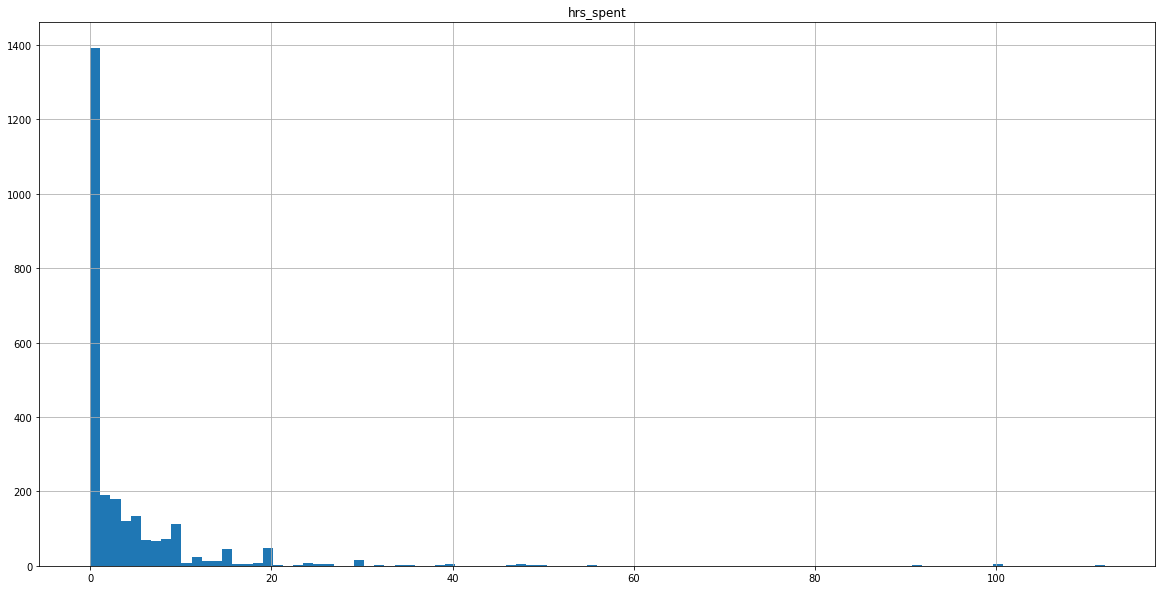

In [87]:
data.hist('hrs_spent', bins = 100, figsize = (20,10))

There are a couple of things that we can take away from this:
1. The distribution is composed of a very large amounts of 0 values
2. We have some much larger values as well causing quite a bit of skewness

To get a precise value on how many zero values compose these data, we can use Pandas:

In [92]:
print(f'Percentage of Data with 0 Values: {round(data["hrs_spent"].value_counts(normalize = True)[0] * 100, 2)}%')

Percentage of Data with 0 Values: 41.65%


Not ideal, but not theoretically uninteresting either. Take IBIS as an example. With 0 hours spent on a platform, we would expect lower relationship to that platform. We also have no basis for throwing out these values either. For example, if we knew that these participants had 0 values because they had never used the platform, we could potentially make an argument for discarding them; however, we do not have this information.

In regards to the values on the larger side, part of the study included participants emailing screenshots of their phone's usage (Screen Time for iOS and Quality Time for Android) to ensure the validity of the data. Thus, the largest values are indeed accurate (although I'm unsure how one spends 100 hours on YouTube...), and we have no basis for discarding them. 

These are points that we will need to take into account when modeling, as this zero-inflation and skewness will undoubtedly influence our coefficients. 

## Brand Ratings

First, I'd like to see the distribution of ratings for each social media platform. Since there were 6 different platforms examined, it's useful to see any differences that need to be taken into account when modeling.

To do this, we'll first create a pivot table to group mean ratings for each platforms. Then, we'll plot these values to get a better picture of any dispersion.

In [76]:
platform_means = pd.pivot_table(data, 
                                values = ['op', 'percep', 'rec', 'use'],
                                index = 'platform').T
platform_means

platform,facebook,instagram,pinterest,snapchat,twitter,youtube
op,3.011710,3.845433,3.669789,3.763466,3.484778,4.110070
percep,2.081967,4.536300,2.414520,4.234192,3.196721,4.943794
rec,3.316159,5.466042,4.105386,5.147541,4.510539,5.908665
use,2.128806,4.466042,1.833724,4.081967,3.030445,3.995316


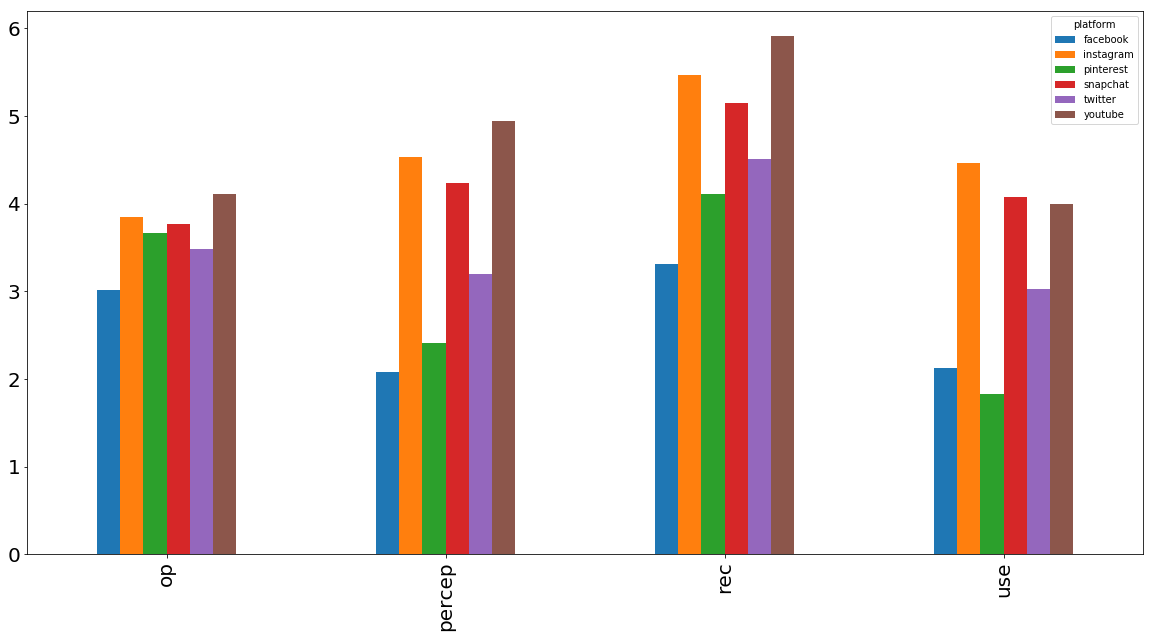

In [77]:
platform_means.plot(kind = 'bar', 
                    figsize = (20,10),
                   fontsize = 20)

There does appear to be some substantial variation between platform ratings. One of the beauties of multilevel modeling is that we will be able to control for these differences using random effects! 

In part 3 where the actual modeling occurs, I'll go into a bit more depth on how we'll evaluate if this is warranted. These initial findings do suggest that accounting for these differences will be a good addition, though. 

## Average Usage Across Time

Since the study did occur over 3 weeks, we can view if usage changes across those time-points. 

Let's take a look at the average time spent - collapsing across platforms - during each week. I don't foresee any big changes (there weren't any major historic events, scandals, etc., during this time), but it's good to do a quick check regardless.

In [78]:
weekly_means = pd.pivot_table(data, 
                                values = 'hrs_spent',
                                index = 'week')
weekly_means

,hrs_spent
week,
1,4.181863
2,3.624049
3,3.819249


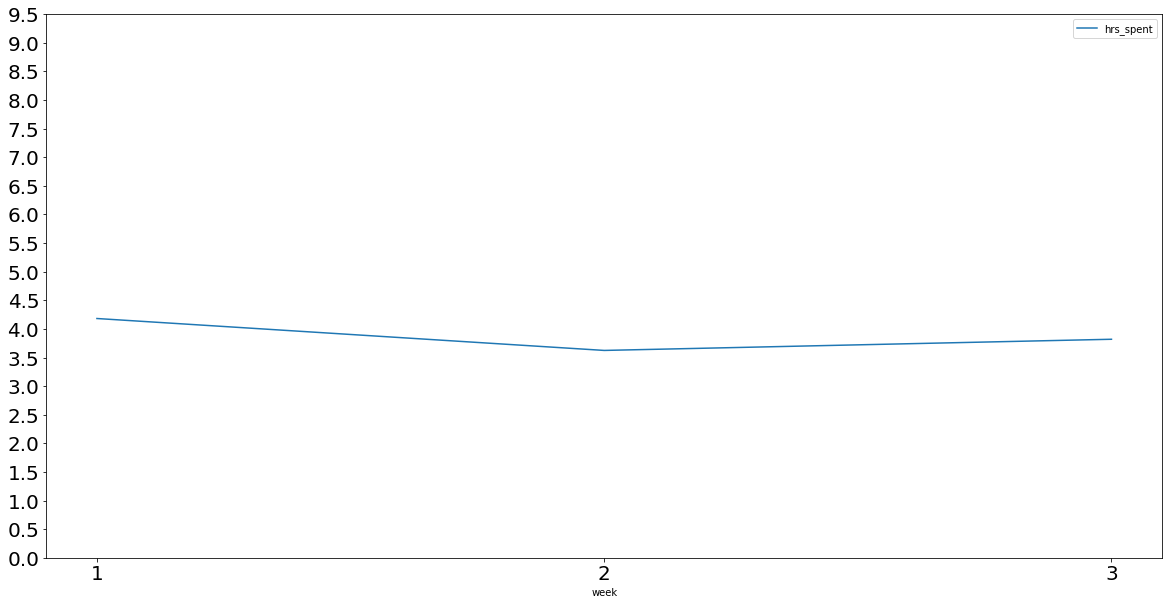

In [79]:
weekly_means.plot(figsize = (20,10),
                  fontsize = 20,
                  xticks = range(1,4),
                  yticks = np.linspace(0,10,20, endpoint = False)
                 )

We can also see if things are as constant for each platform as well.

In [47]:
platform_weekly_means = pd.pivot_table(data, values = 'hrs_spent',
                                index = ['platform','week']).unstack(level = 0)
platform_weekly_means

hrs_spent                                                  
platform  facebook instagram pinterest  snapchat   twitter   youtube
week                                                                
1         1.088235  6.925735  0.647059  6.054412  3.652206  6.723529
2         1.095302  6.114765  0.651007  5.002013  2.584631  6.296577
3         1.253521  6.577465  0.669014  5.137324  3.378873  5.899296

In [ ]:
###Not present in Part 2 - figure generated for use in part 3###

In [28]:
participant_weekly_means = pd.pivot_table(data, values = 'hrs_spent',
                                index = ['participant','week']).unstack(level = 0)

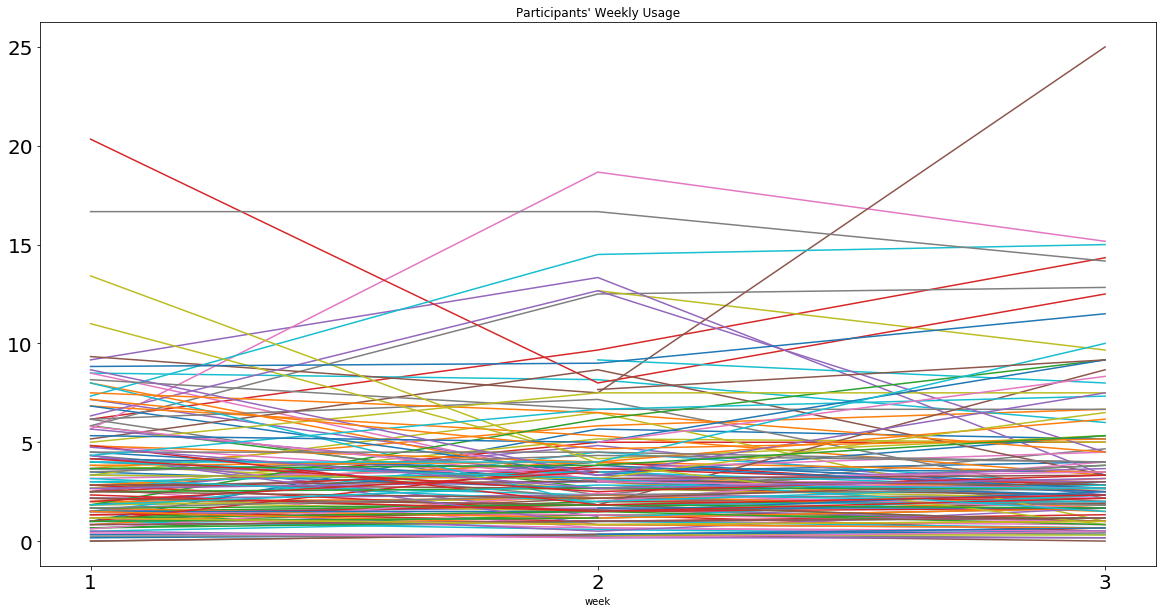

In [32]:
part_ax = participant_weekly_means.plot(figsize = (20,10),
                                fontsize = 20,
                                xticks = range(1,4),
                                legend = False,
                                title = "Participants' Weekly Usage" 
                               )

In [ ]:
#######

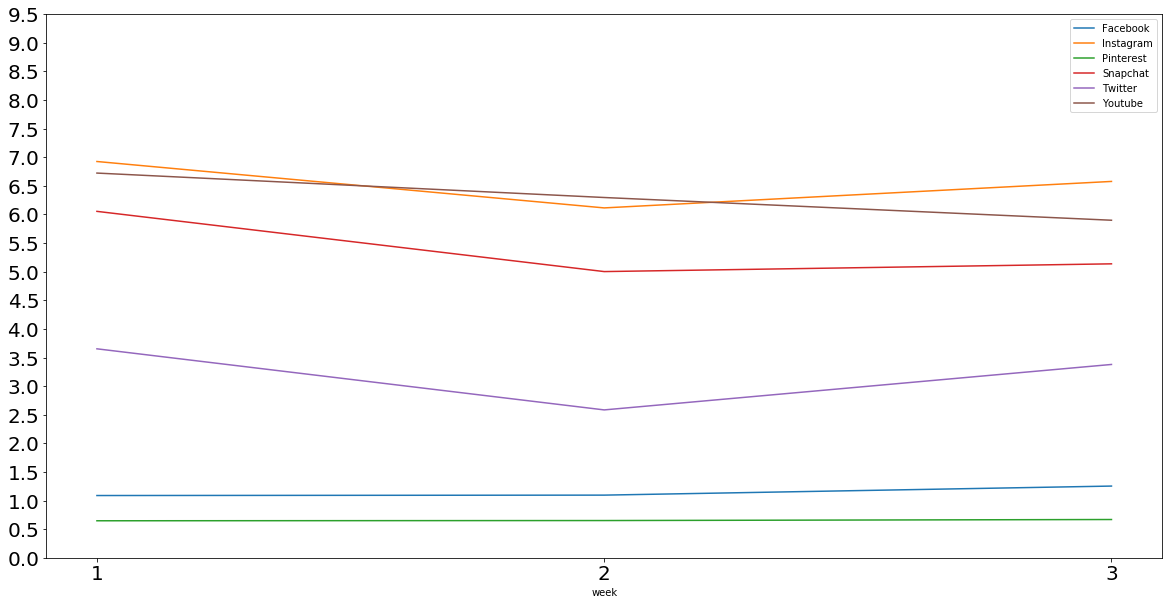

In [46]:
ax = platform_weekly_means.plot(figsize = (20,10),
                                fontsize = 20,
                                xticks = range(1,4),
                                yticks = np.linspace(0,10,20, endpoint = False)
                               )
ax.legend(['Facebook', 'Instagram', 'Pinterest', 'Snapchat', 'Twitter', 'Youtube'])

There's some variation for each platform throughout weeks, but this is expected, and it does not appear to be too drastic. There are substantial differences in the average amounts of time spent on each platform, though.

We found differences in platform ratings above, and this is further evidence of differences in usage as well. Instagram, for example, receives, on average, 6-6.5 hours more usage per week than Pinterest.  

# Collinearity

Since all of our future predictors (overall opinion, IBIS, likelihood to recommend, and use intent) theoretically measure similar constructs, we'll most likely see some fairly strong correlations between them.

We can use Pandas to examine these.

In [43]:
data[['op', 'percep', 'rec','use']].corr()

,op,percep,rec,use
op,1.000000,0.592147,0.657252,0.504367
percep,0.592147,1.000000,0.726923,0.805629
rec,0.657252,0.726923,1.000000,0.696250
use,0.504367,0.805629,0.696250,1.000000


Indeed, we see Pearson correlation coefficients between 0.51 - 0.81, which are moderate - strong correlations. Although some argue that correlations > 0.9 (or even higher) are when concerns start, these variable correlations will also need to be kept in mind. 

When we fit the actual models, we can also use the VIF to check for multicollinearity in the regressions, which I'll go into greater depth in, in the next post. 

# Summary

There are several takeaways from this EDA that will assist in modeling:
1. Hours spent across platforms varies wildly, and is heavily zero-inflated and skewed. If significant issues arise, further action will need to be taken (e.g., transformations), but for now, we can assume from the experiment that is representative of our population.
2. There are substantial differences in both ratings and usage of social media platforms, so we will most likely need to model platforms as a random effect.
3. There are moderate-strong correlations between our predictors. This is something that needs to be taken into account using a measure of multicollinearity in the model (e.g., VIF) - we may also model them separately to get their effect alone. 